Logging to ./results/breakout2_a2c
Logging to ./results/breakout2_dqn
Training DQN...
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 151      |
|    time_elapsed     | 0        |
|    total_timesteps  | 25       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 256      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 305      |
|    time_elapsed     | 0        |
|    total_timesteps  | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.999    |
| time/               |          |
|   

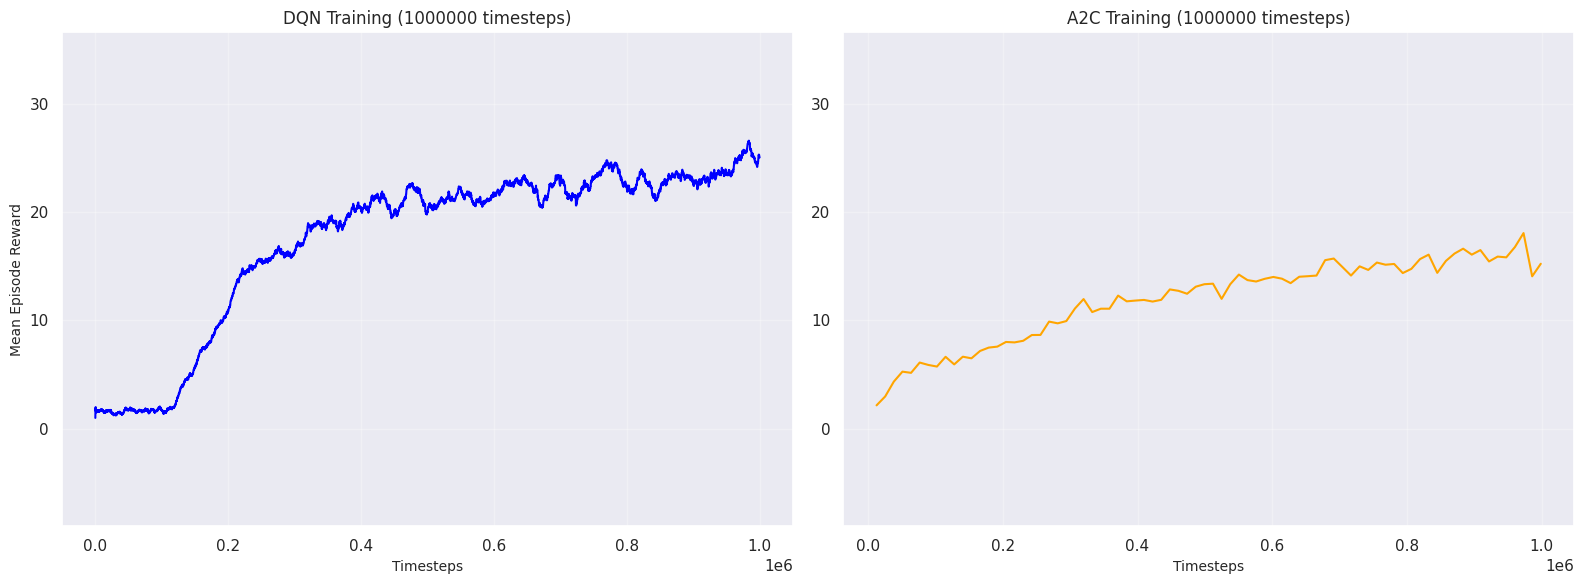

In [6]:
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ale_py
import gymnasium as gym

gym.register_envs(ale_py)


os.makedirs("models", exist_ok=True)
os.makedirs("results/breakout2_a2c", exist_ok=True)
os.makedirs("results/breakout2_dqn", exist_ok=True)


total_timesteps = 1000000


a2c_log_path = "./results/breakout2_a2c"
dqn_log_path = "./results/breakout2_dqn"
a2c_logger = configure(a2c_log_path, ["csv", "stdout"])
dqn_logger = configure(dqn_log_path, ["csv", "stdout"])


env = make_atari_env('Breakout-v4', n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)


model_dqn = DQN(
    policy="CnnPolicy",
    env=env,
    learning_rate=0.00025,
    buffer_size=100000,
    batch_size=32,
    gamma=0.99,
    target_update_interval=10000,
    exploration_fraction=0.2,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.01,
    learning_starts=50000,
    device='cuda',
)

model_dqn.set_logger(dqn_logger)
print("Training DQN...")
model_dqn.learn(total_timesteps=total_timesteps)
model_dqn.save("models/dqn_breakout2")


mean_reward_dqn, std_reward_dqn = evaluate_policy(model_dqn, model_dqn.get_env(), n_eval_episodes=10)
print(f'DQN Mean reward: {mean_reward_dqn} +/- {std_reward_dqn:.2f}')


model_a2c = A2C(
    policy="CnnPolicy",
    env=env,
    learning_rate=0.0007,
    n_steps=128,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    device='cuda',
)

model_a2c.set_logger(a2c_logger)
print("Training A2C...")
model_a2c.learn(total_timesteps=total_timesteps)
model_a2c.save("models/a2c_breakout2")


mean_reward_a2c, std_reward_a2c = evaluate_policy(model_a2c, model_a2c.get_env(), n_eval_episodes=10)
print(f'A2C Mean reward: {mean_reward_a2c} +/- {std_reward_a2c:.2f}')


try:
    a2c_log_data = pd.read_csv(f"{a2c_log_path}/progress.csv")
    dqn_log_data = pd.read_csv(f"{dqn_log_path}/progress.csv")
    
    a2c_log_data['Algorithm'] = 'A2C'
    dqn_log_data['Algorithm'] = 'DQN'

    sns.set_theme(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(x="time/total_timesteps", y="rollout/ep_rew_mean", data=dqn_log_data, ax=ax1, color="blue")
    ax1.set_title(f"DQN Training ({total_timesteps} timesteps)", fontsize=12)
    ax1.set_xlabel("Timesteps", fontsize=10)
    ax1.set_ylabel("Mean Episode Reward", fontsize=10)
    ax1.grid(True, alpha=0.3)

    sns.lineplot(x="time/total_timesteps", y="rollout/ep_rew_mean", data=a2c_log_data, ax=ax2, color="orange")
    ax2.set_title(f"A2C Training ({total_timesteps} timesteps)", fontsize=12)
    ax2.set_xlabel("Timesteps", fontsize=10)
    ax2.set_ylabel("")
    ax2.grid(True, alpha=0.3)

    y_min = min(dqn_log_data["rollout/ep_rew_mean"].min(), a2c_log_data["rollout/ep_rew_mean"].min()) - 10
    y_max = max(dqn_log_data["rollout/ep_rew_mean"].max(), a2c_log_data["rollout/ep_rew_mean"].max()) + 10
    
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"Error loading log files: {e}")
    print("Please check if the CSV files were created in the results directory.")

env.close()